In [144]:
# ==================================== Start PMX – Define Base Directory =============================================
from pathlib import Path

base_dir = Path(r"C:\Users\samue\OneDrive - OST\Master_Mechatronics_Automation_OST\3_HS_Mechatronics_Automation_OST_2025\03_projektarbeit_ntu\80_Data\2025.09.10\90_model_data")

# Example: test the listing
for f in base_dir.glob("*.xlsx"):
    print(f.name)
# ==================================== End PMX – Define Base Directory =============================================


curvefit_rosbag2_2025_09_10-09_43_59_Pitch_20251027-172219.xlsx
curvefit_rosbag2_2025_09_10-09_46_03_Roll_20251027-165009.xlsx
curvefit_rosbag2_2025_09_10-10_04_48_Yaw_20251027-150059.xlsx
curvefit_rosbag2_2025_09_10-10_05_20_Yaw_20251027-150231.xlsx
curvefit_rosbag2_2025_09_10-10_08_44_sync_Surge_20251103-175549.xlsx
curvefit_rosbag2_2025_09_10-10_12_39_sync_Surge_20251103-181039.xlsx
curvefit_rosbag2_2025_09_10-10_15_43_sync_Sway_20251105-232559.xlsx
curvefit_rosbag2_2025_11_04-10_11_35_sync_Heave_20251106-021255_5N.xlsx
curvefit_rosbag2_2025_11_04-10_24_38_sync_Heave_20251106-020835_10N.xlsx
heave_results_OpenRig_(thruster-controlled)_20251027-021420.xlsx
pitch_results_OpenRig_(thruster-controlled)_20251027-172005.xlsx
roll_results_OpenRig_(thruster-controlled)_20251027-163937.xlsx
surge_results_OpenRig_(thruster-controlled)_20251103-220614.xlsx
sway_results_OpenRig_(thruster-controlled)_20251105-235348.xlsx
yaw_results_OpenRig_(thruster-controlled)_20251027-133440.xlsx


In [145]:
# ==================================== Start PMX – Match File Pairs =============================================
motions = ["Surge", "Sway", "Heave", "Roll", "Pitch", "Yaw"]

file_pairs = []  # each item: (motion, [real_paths...], sim_path)

for m in motions:
    # Real files like: curvefit_rosbag2_..._{Motion}_YYYYMMDD-...xlsx
    reals = sorted(base_dir.glob(f"curvefit_*_{m}_*.xlsx"))
    # keep at most two real datasets
    reals = reals[:4]

    # Sim files like: heave_results_OpenRig_(thruster-controlled)_...
    sim = next(base_dir.glob(f"*{m.lower()}*_OpenRig_*.xlsx"), None)

    if reals and sim:
        file_pairs.append((m, reals, sim))

print("Found file groups:")
for m, reals, sim in file_pairs:
    print(f"{m}:")
    for i, r in enumerate(reals, 1):
        print(f"   Real {i}: {r.name}")
    print(f"   Sim    : {sim.name}")
# ==================================== End PMX – Match File Pairs =============================================


Found file groups:
Surge:
   Real 1: curvefit_rosbag2_2025_09_10-10_08_44_sync_Surge_20251103-175549.xlsx
   Real 2: curvefit_rosbag2_2025_09_10-10_12_39_sync_Surge_20251103-181039.xlsx
   Sim    : surge_results_OpenRig_(thruster-controlled)_20251103-220614.xlsx
Sway:
   Real 1: curvefit_rosbag2_2025_09_10-10_15_43_sync_Sway_20251105-232559.xlsx
   Sim    : sway_results_OpenRig_(thruster-controlled)_20251105-235348.xlsx
Heave:
   Real 1: curvefit_rosbag2_2025_11_04-10_11_35_sync_Heave_20251106-021255_5N.xlsx
   Real 2: curvefit_rosbag2_2025_11_04-10_24_38_sync_Heave_20251106-020835_10N.xlsx
   Sim    : heave_results_OpenRig_(thruster-controlled)_20251027-021420.xlsx
Roll:
   Real 1: curvefit_rosbag2_2025_09_10-09_46_03_Roll_20251027-165009.xlsx
   Sim    : roll_results_OpenRig_(thruster-controlled)_20251027-163937.xlsx
Pitch:
   Real 1: curvefit_rosbag2_2025_09_10-09_43_59_Pitch_20251027-172219.xlsx
   Sim    : pitch_results_OpenRig_(thruster-controlled)_20251027-172005.xlsx
Yaw:
   Re

In [146]:
# =========================== File 3: compare + helpers (final rewrite) ===========================
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path


# --- zero-height controls (0 = bottom, 1 = top) ---
ZERO_FRAC_LINEAR = 0.10      # Surge/Sway/Heave (left axis)
ZERO_FRAC_ROLL   = 0.30      # Roll angle   (left axis)
ZERO_FRAC_PITCH  = 0.30      # Pitch angle  (left axis)
ZERO_FRAC_YAW    = 0.10      # Yaw angle    (left axis)

# Right axis (rate/velocity) behavior:
# - If ANGULAR and this is None, the right axis MATCHES the left axis fraction (zeros align).
# - Set a number (e.g., 0.30) to force a different zero height on the right axis.
ZERO_FRAC_RATE_OVERRIDE = None
ZERO_FRAC_VEL_LINEAR    = 0.10
PAD_RATIO               = 0.05

# ---------- Fossen-style axis labels ----------
FOSSEN_LABELS = {
    "Surge":  {"left": r"$x_b$ [m]",      "right": r"$u$ [m/s]",       "title": "surge"},
    "Sway":   {"left": r"$y_b$ [m]",      "right": r"$v$ [m/s]",       "title": "sway"},
    "Heave":  {"left": r"$z_b$ [m]",      "right": r"$w$ [m/s]",       "title": "heave"},
    "Roll":   {"left": r"$\phi$ [rad]",   "right": r"$p$ [rad/s]",     "title": "roll"},
    "Pitch":  {"left": r"$\theta$ [rad]", "right": r"$q$ [rad/s]",     "title": "pitch"},
    "Yaw":    {"left": r"$\psi$ [rad]",   "right": r"$r$ [rad/s]",     "title": "yaw"},
}

# -------------------- basics --------------------
def _extract_dataset_tag_from_filename(path, motion):
    stem = Path(path).stem
    m = re.search(r"rosbag2_([^_]+(?:_[^_]+){2})_sync", stem, flags=re.IGNORECASE)
    if m: return m.group(1)
    m = re.search(r"(\d{4}[_-]\d{2}[_-]\d{2}[-_]\d{2}[_-]\d{2}[_-]\d{2})", stem)
    if m: return m.group(1)
    try:
        pre = stem.split(f"_{motion}_")[0]
        pre = re.sub(r"^curvefit_?", "", pre, flags=re.IGNORECASE)
        toks = [t for t in pre.split("_") if t]
        if toks:
            for k in (4, 3, 2):
                if len(toks) >= k:
                    cand = "_".join(toks[-k:])
                    if re.search(r"\d{4}[_-]\d{2}[_-]\d{2}", cand):
                        return cand
            return toks[-1]
    except Exception:
        pass
    return stem

def _is_angular(motion: str) -> bool:
    return motion.lower() in {"roll", "pitch", "yaw"}

def _zero_fracs(motion: str, angular: bool):
    ml = motion.lower()
    if angular:
        f_left = {"roll": ZERO_FRAC_ROLL, "pitch": ZERO_FRAC_PITCH, "yaw": ZERO_FRAC_YAW}.get(ml, ZERO_FRAC_YAW)
        f_right = f_left if ZERO_FRAC_RATE_OVERRIDE is None else float(ZERO_FRAC_RATE_OVERRIDE)
    else:
        f_left  = ZERO_FRAC_LINEAR
        f_right = ZERO_FRAC_VEL_LINEAR
    return f_left, f_right

# -------------------- data getters --------------------
def _get_displacement_column(df_real: pd.DataFrame):
    """Linear displacement (meters), legacy fallbacks."""
    for col in ["displacement_m", "displacement_fit_m", "displacement_raw_m"]:
        if col in df_real.columns:
            return df_real[col].to_numpy(dtype=float)
    return None

def _get_angle_column(df_real: pd.DataFrame, motion: str):
    """
    Angular position in radians (unwrap).
    • Roll/Pitch: DO NOT zero — return absolute unwrapped angle.
    • Yaw: unwrap and zero to start.
    Accepts displacement_* (legacy angle), angle_rad, and phi/theta/psi.
    """
    ml = motion.lower()

    # 1) Legacy displacement_* sometimes stores the angle (use as-is → unwrap)
    for col in ["displacement_m", "displacement_fit_m", "displacement_raw_m"]:
        if col in df_real.columns:
            ang = df_real[col].to_numpy(dtype=float)
            ang = np.unwrap(ang)
            return ang if ml in {"roll", "pitch"} else (ang - (ang[0] if ang.size else 0.0))

    # 2) angle_rad
    if "angle_rad" in df_real.columns:
        ang = df_real["angle_rad"].to_numpy(dtype=float)
        ang = np.unwrap(ang)
        return ang if ml in {"roll", "pitch"} else (ang - (ang[0] if ang.size else 0.0))

    # 3) explicit axis names (assume radians unless header says deg/°)
    axis_cols = {
        "roll":  ["phi", "roll"],
        "pitch": ["theta", "pitch"],
        "yaw":   ["psi", "yaw", "heading"],
    }[ml]

    for col in axis_cols:
        if col in df_real.columns:
            a = df_real[col].to_numpy(dtype=float)
            if re.search(r"(deg|°)", col, flags=re.IGNORECASE):
                a = np.deg2rad(a)
            a = np.unwrap(a)
            return a if ml in {"roll", "pitch"} else (a - (a[0] if a.size else 0.0))

    return None

def _get_rate_column(df_real: pd.DataFrame, motion: str):
    """
    Angular rate in rad/s for roll/pitch/yaw.
    Convert ONLY if column header explicitly contains deg/°.
    Also accepts 'speed_mps' as the empirical rate column for roll/yaw,
    since your exports use that name.
    """
    ml = motion.lower()

    def _find_regex(patterns):
        for pat in patterns:
            rx = re.compile(pat, flags=re.IGNORECASE)
            for c in df_real.columns:
                if rx.search(str(c)):
                    return str(c)
        return None

    if ml == "roll":
        patts = [r"^p$", r"\b(roll|phi)[ _-]?(rate|dot)\b", r"\brate[ _-]?radps\b", r"\bangular[ _-]?rate\b"]
    elif ml == "pitch":
        patts = [r"^q$", r"\b(pitch|theta)[ _-]?(rate|dot)\b", r"\brate[ _-]?radps\b", r"\bangular[ _-]?rate\b"]
    else:  # yaw
        patts = [
            r"^r$",
            r"\b(yaw|psi|heading)[ _-]?(rate|dot)\b",
            r"\brate[ _-]?radps\b",
            r"\bangular[ _-]?rate\b",
            r"\bgyro.*z\b",
        ]

    # 1) Try canonical/regex names first
    col = _find_regex(patts)

    # 2) Fallback for your empirical files: 'speed_mps' carries the angular rate
    if col is None and 'speed_mps' in df_real.columns:
        col = 'speed_mps'

    if col is None:
        return None

    arr = df_real[col].to_numpy(dtype=float)
    if re.search(r"(deg|°)", col, flags=re.IGNORECASE):
        arr = np.deg2rad(arr)  # deg/s → rad/s
    return arr

# -------------------- axis helper --------------------
def _limits_with_zero_at_fraction(dmin, dmax, f, pad_ratio=PAD_RATIO):
    if not (np.isfinite(dmin) and np.isfinite(dmax)):
        dmin, dmax = -1.0, 1.0
    if dmax < dmin:
        dmin, dmax = dmax, dmin
    f = float(np.clip(f, 1e-9, 1-1e-9))
    need_top = dmax / max(1e-12, (1 - f)) if (1 - f) > 0 else np.inf
    need_bot = -dmin / max(1e-12, f)       if f > 0 else np.inf
    S = max(need_top, need_bot, 1e-12)
    lo = -f * S
    hi = (1 - f) * S
    pad = pad_ratio * (hi - lo)
    return lo - pad, hi + pad

# -------------------- main --------------------
def compare_motion_multiple_reals(
    real_paths,
    sim_path,
    motion,
    cols_map,
    default_time_shift=-4.0,
    time_shifts_by_tag=None,
    time_window=(0, 12.5),
    plots_dir=None
):
    if time_shifts_by_tag is None:
        time_shifts_by_tag = {}

    ang_mode = _is_angular(motion)
    f_left, f_right = _zero_fracs(motion, ang_mode)

    # --- Model ---
    df_sim = pd.read_excel(sim_path, sheet_name="states")
    t_sim  = df_sim['time'].to_numpy() if 'time' in df_sim.columns else np.arange(len(df_sim))
    pos_sim = df_sim[cols_map['pos']].to_numpy() if cols_map['pos'] in df_sim.columns else None
    vel_sim = df_sim[cols_map['vel']].to_numpy() if cols_map['vel'] in df_sim.columns else None

    if time_window is not None:
        t_min, t_max = time_window
        sm = (t_sim >= t_min) & (t_sim <= t_max)
        t_sim_plot = t_sim[sm]
        pos_sim_plot = pos_sim[sm] if pos_sim is not None else None
        vel_sim_plot = vel_sim[sm] if vel_sim is not None else None
    else:
        t_sim_plot, pos_sim_plot, vel_sim_plot = t_sim, pos_sim, vel_sim

    # Unwrap model angle:
    # • Roll/Pitch: unwrap only (no zeroing)
    # • Yaw: unwrap + zero at start
    if ang_mode and pos_sim_plot is not None:
        pos_sim_plot = np.unwrap(pos_sim_plot.copy())
        if motion.lower() == "yaw":
            pos_sim_plot = pos_sim_plot - (pos_sim_plot[0] if pos_sim_plot.size else 0.0)

    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax2 = ax1.twinx()

    pos_vals, vel_vals = [], []
    empirical_colors = [
        "tab:orange","tab:green","tab:purple","tab:brown",
        "tab:pink","tab:gray","tab:olive","tab:cyan","tab:blue","tab:red"
    ]
    color_idx = 0
    tags_used = []

    for rpath in real_paths:
        df_real = pd.read_excel(rpath)

        # time
        t_real = df_real['time_s'].to_numpy() if 'time_s' in df_real.columns else np.arange(len(df_real), dtype=float)

        # data (simple & explicit)
        if ang_mode:
            pos_real = _get_angle_column(df_real, motion)  # rad (roll/pitch absolute; yaw zeroed)
            vel_real = _get_rate_column(df_real, motion)   # rad/s
        else:
            pos_real = _get_displacement_column(df_real)   # m
            vel_real = df_real['speed_mps'].to_numpy() if 'speed_mps' in df_real.columns else None  # m/s

        tag = _extract_dataset_tag_from_filename(Path(rpath), motion)
        tags_used.append(tag)
        t_shift = time_shifts_by_tag.get(tag, default_time_shift)

        # shift & mask
        t_real_shifted = t_real + t_shift
        if time_window is not None:
            mask = (t_real_shifted >= t_min) & (t_real_shifted <= t_max)
            t_real_shifted = t_real_shifted[mask]
            if pos_real is not None and len(pos_real) == len(t_real):
                pos_real = pos_real[mask]
            if vel_real is not None and len(vel_real) == len(t_real):
                vel_real = vel_real[mask]

        # Plot empirical position/angle
        if pos_real is not None:
            c = empirical_colors[color_idx % len(empirical_colors)]; color_idx += 1
            ax1.plot(t_real_shifted, pos_real, "-", lw=2, color=c,
                     label=f"empirical {FOSSEN_LABELS[motion]['title']} {'angle' if ang_mode else 'pos'} {tag}")
            pos_vals.append(np.asarray(pos_real))
        else:
            if ang_mode:
                print(f"[Warn] No angular column found in {Path(rpath).name} (expected displacement_* or angle_rad or phi/theta/psi).")
            else:
                print(f"[Warn] No displacement column in {Path(rpath).name} (expected displacement_*).")

        # Plot empirical velocity/rate
        if vel_real is not None:
            c = empirical_colors[color_idx % len(empirical_colors)]; color_idx += 1
            ax2.plot(t_real_shifted, vel_real, "-", lw=2, color=c,
                     label=f"empirical {FOSSEN_LABELS[motion]['title']} {'rate' if ang_mode else 'vel'} {tag}")
            vel_vals.append(np.asarray(vel_real))
        else:
            if ang_mode:
                print(f"[Warn] No angular rate column in {Path(rpath).name} (expected p/q/r or *_rate or rate_radps).")
            else:
                print(f"[Warn] No 'speed_mps' column in {Path(rpath).name}.")

    # Model overlays
    if pos_sim_plot is not None:
        ax1.plot(t_sim_plot, pos_sim_plot, "--", lw=1.8, color="tab:blue",
                 label=f"model {FOSSEN_LABELS[motion]['title']} {'angle' if ang_mode else 'pos'}")
        pos_vals.append(np.asarray(pos_sim_plot))
    if vel_sim_plot is not None:
        ax2.plot(t_sim_plot, vel_sim_plot, "--", lw=1.8, color="tab:red",
                 label=f"model {FOSSEN_LABELS[motion]['title']} {'rate' if ang_mode else 'vel'}")
        vel_vals.append(np.asarray(vel_sim_plot))

    # Labels / grid (Fossen style)
    ax1.set_xlabel("Time [s]")
    ax1.set_ylabel(FOSSEN_LABELS[motion]["left"], color="tab:blue")
    ax1.tick_params(axis='y', labelcolor="tab:blue")
    ax1.grid(True, linestyle=":", alpha=0.6)

    ax2.set_ylabel(FOSSEN_LABELS[motion]["right"], color="tab:red")
    ax2.tick_params(axis='y', labelcolor="tab:red")

    # ----- Place y=0 at chosen height (independent scales) -----
    if pos_vals:
        p_all = np.concatenate(pos_vals)
        pmin, pmax = np.nanmin(p_all), np.nanmax(p_all)
        y1min, y1max = _limits_with_zero_at_fraction(pmin, pmax, f=f_left, pad_ratio=PAD_RATIO)
        ax1.set_ylim(y1min, y1max)

    if vel_vals:
        v_all = np.concatenate(vel_vals)
        vmin, vmax = np.nanmin(v_all), np.nanmax(v_all)
        y2min, y2max = _limits_with_zero_at_fraction(vmin, vmax, f=f_right, pad_ratio=PAD_RATIO)
        ax2.set_ylim(y2min, y2max)

    # Zero reference lines on BOTH axes
    ax1.axhline(0, color="0.7", lw=1, ls="--", zorder=0)
    ax2.axhline(0, color="0.7", lw=1, ls="--", zorder=0)

    # Legend (merged)
    l1, lab1 = ax1.get_legend_handles_labels()
    l2, lab2 = ax2.get_legend_handles_labels()
    ax1.legend(l1 + l2, lab1 + lab2, loc="best", frameon=False)

    # Title
    if tags_used:
        plt.title(f"{FOSSEN_LABELS[motion]['title']}: empirical vs model — {' & '.join(tags_used)} (window={time_window})")
    else:
        plt.title(f"{FOSSEN_LABELS[motion]['title']}: empirical vs model (window={time_window})")

    plt.tight_layout()
    if plots_dir is not None:
        out_path = Path(plots_dir) / f"{motion}_{'+'.join(tags_used) if tags_used else 'empirical'}_Combined.png"
        plt.savefig(out_path, dpi=300)
        print(f"[Save] {out_path}")
    plt.show()
# ===========================================================================================================



==================================== Comparing Surge ============================================
[Warn] No 'speed_mps' column in curvefit_rosbag2_2025_09_10-10_08_44_sync_Surge_20251103-175549.xlsx.
[Warn] No 'speed_mps' column in curvefit_rosbag2_2025_09_10-10_12_39_sync_Surge_20251103-181039.xlsx.
[Save] C:\Users\samue\OneDrive - OST\Master_Mechatronics_Automation_OST\3_HS_Mechatronics_Automation_OST_2025\03_projektarbeit_ntu\80_Data\2025.09.10\90_model_data\plots\Surge_2025_09_10-10_08_44+2025_09_10-10_12_39_Combined.png


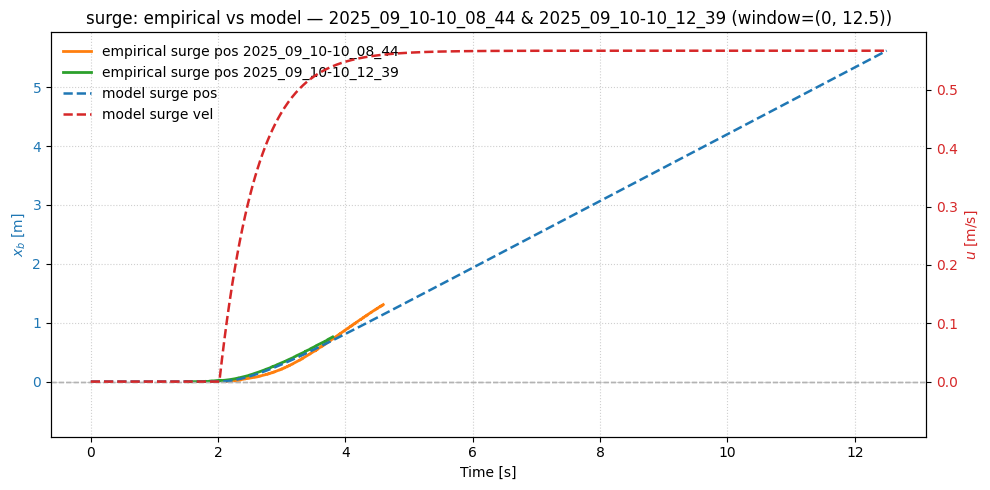


==================================== Comparing Sway ============================================
[Warn] No 'speed_mps' column in curvefit_rosbag2_2025_09_10-10_15_43_sync_Sway_20251105-232559.xlsx.
[Save] C:\Users\samue\OneDrive - OST\Master_Mechatronics_Automation_OST\3_HS_Mechatronics_Automation_OST_2025\03_projektarbeit_ntu\80_Data\2025.09.10\90_model_data\plots\Sway_2025_09_10-10_15_43_Combined.png


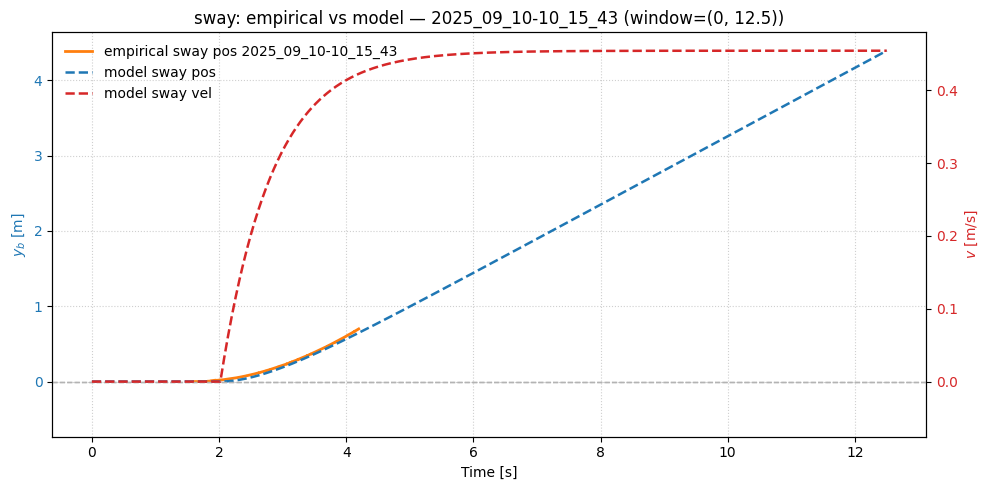


==================================== Comparing Heave ============================================
[Save] C:\Users\samue\OneDrive - OST\Master_Mechatronics_Automation_OST\3_HS_Mechatronics_Automation_OST_2025\03_projektarbeit_ntu\80_Data\2025.09.10\90_model_data\plots\Heave_2025_11_04-10_11_35+2025_11_04-10_24_38_Combined.png


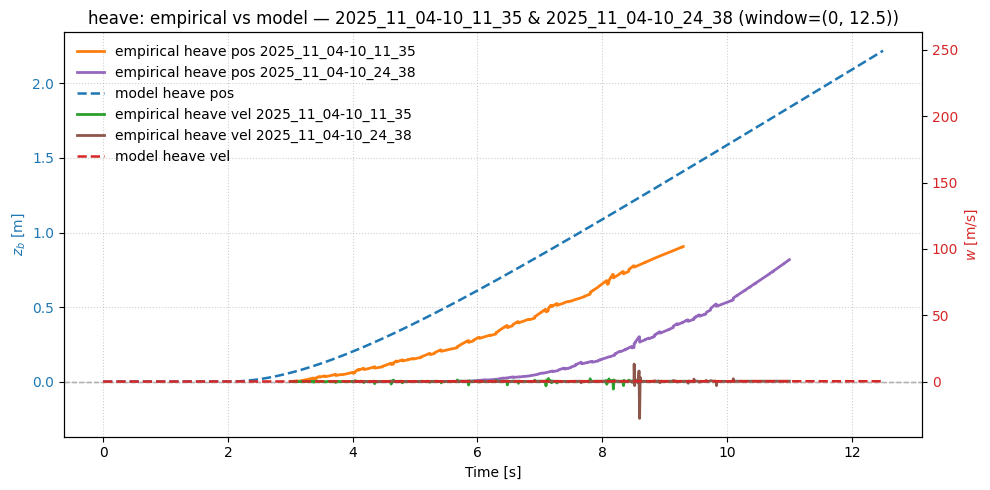


==================================== Comparing Roll ============================================
[Save] C:\Users\samue\OneDrive - OST\Master_Mechatronics_Automation_OST\3_HS_Mechatronics_Automation_OST_2025\03_projektarbeit_ntu\80_Data\2025.09.10\90_model_data\plots\Roll_2025_09_10-09_46_03_Combined.png


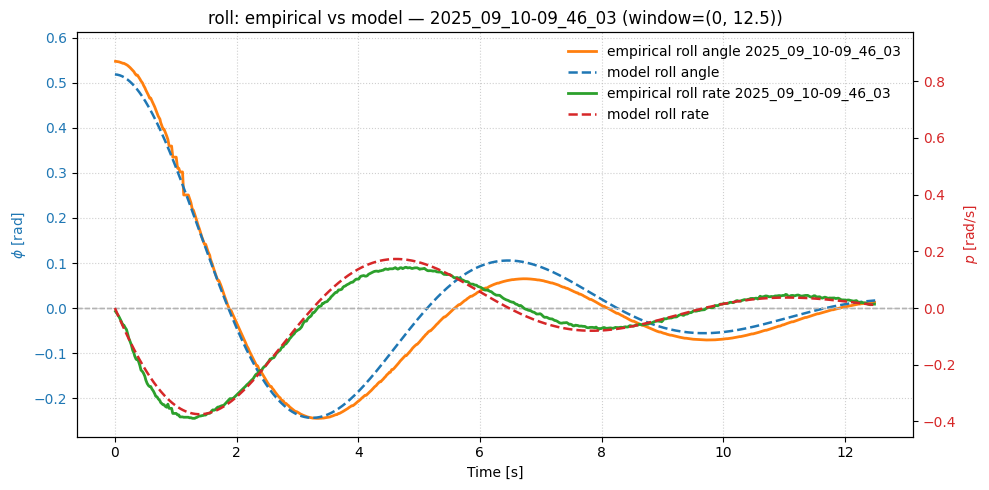


==================================== Comparing Pitch ============================================
[Save] C:\Users\samue\OneDrive - OST\Master_Mechatronics_Automation_OST\3_HS_Mechatronics_Automation_OST_2025\03_projektarbeit_ntu\80_Data\2025.09.10\90_model_data\plots\Pitch_2025_09_10-09_43_59_Combined.png


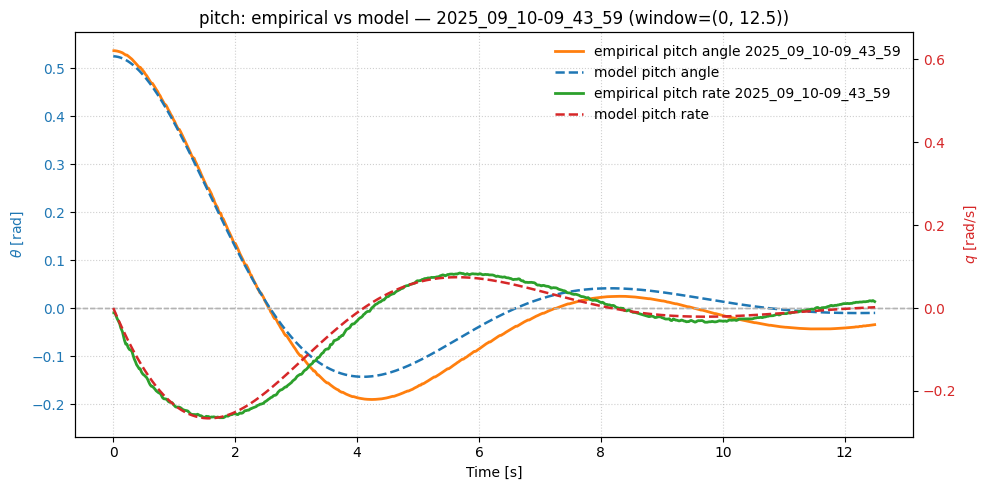


==================================== Comparing Yaw ============================================
[Warn] No angular rate column in curvefit_rosbag2_2025_09_10-10_04_48_Yaw_20251027-150059.xlsx (expected p/q/r or *_rate or rate_radps).
[Warn] No angular rate column in curvefit_rosbag2_2025_09_10-10_05_20_Yaw_20251027-150231.xlsx (expected p/q/r or *_rate or rate_radps).
[Save] C:\Users\samue\OneDrive - OST\Master_Mechatronics_Automation_OST\3_HS_Mechatronics_Automation_OST_2025\03_projektarbeit_ntu\80_Data\2025.09.10\90_model_data\plots\Yaw_2025_09_10-10_04_48+2025_09_10-10_05_20_Combined.png


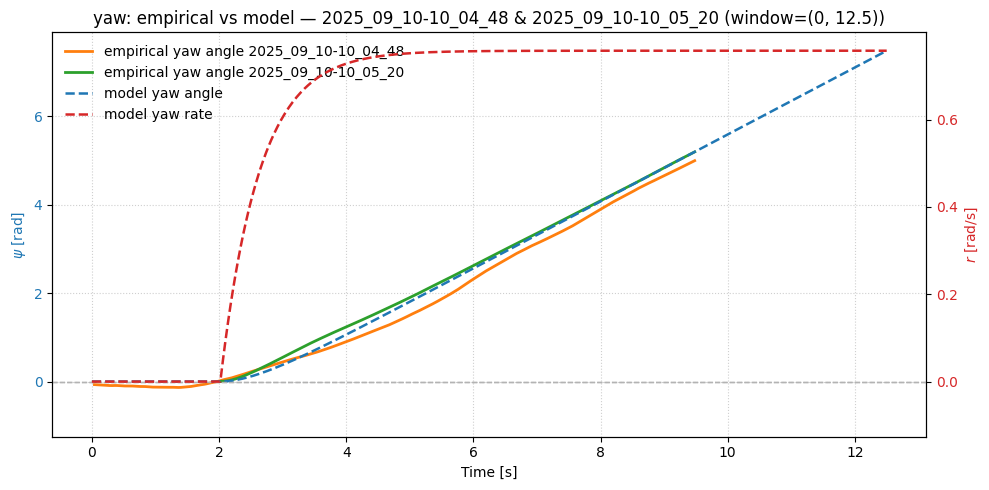


✅ All comparisons done! Combined plots saved in: C:\Users\samue\OneDrive - OST\Master_Mechatronics_Automation_OST\3_HS_Mechatronics_Automation_OST_2025\03_projektarbeit_ntu\80_Data\2025.09.10\90_model_data\plots


In [147]:
# ====================== File 4: auto run all comparisons (adjusted) ==========================
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

# Motion → column mapping for model data
cols_mapping = {
    "Surge": {"pos": "x",     "vel": "u"},
    "Sway":  {"pos": "y",     "vel": "v"},
    "Heave": {"pos": "z",     "vel": "w"},
    "Roll":  {"pos": "phi",   "vel": "p"},   # rad / rad/s
    "Pitch": {"pos": "theta", "vel": "q"},   # rad / rad/s
    "Yaw":   {"pos": "psi",   "vel": "r"},   # rad / rad/s
}

# Global default shift and optional per-dataset tweaks
default_time_shift = 1
time_shifts_by_tag = {
     "2025_09_10-10_24_41": -9,
     "2025_09_10-10_25_31": -4,
     "2025_09_10-10_08_44": -10.4,
     "2025_09_10-10_12_39": -10.2,
     "2025_09_10-10_10_09": -14,
     "2025_09_10-10_15_43": -8.4,
     "2025_09_10-10_16_53": -6.5,
     "2025_09_10-10_04_48": -1.5,
     "2025_09_10-10_05_20": -0.5,
     "2025_09_10-09_46_03": -0.65,
     "2025_09_10-09_43_59": -27,
}

# Output directory
plots_dir = base_dir / "plots"  # assumes base_dir is defined earlier in your notebook/script
plots_dir.mkdir(exist_ok=True)

for m, reals, sim in file_pairs:  # assumes file_pairs is defined as before
    print(f"\n==================================== Comparing {m} ============================================")
    compare_motion_multiple_reals(
        real_paths=reals,
        sim_path=sim,
        motion=m,
        cols_map=cols_mapping[m],
        default_time_shift=default_time_shift,
        time_shifts_by_tag=time_shifts_by_tag,
        time_window=(0, 12.5),
        plots_dir=plots_dir
    )

print(f"\n✅ All comparisons done! Combined plots saved in: {plots_dir}")
# =============================================================================================


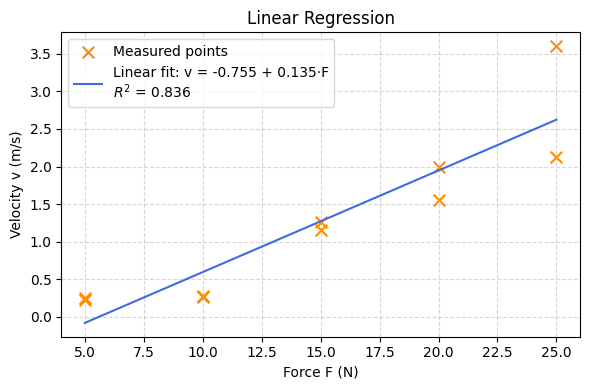

alpha = -0.754900
beta  = 0.135100
R²    = 0.836


In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Data (Force [N], Velocity [m/s])
data = [
    (5, 0.23), (5, 0.25),
    (10, 0.26), (10, 0.28),
    (15, 1.266), (15, 1.15),
    (20, 1.55), (20, 2.00),
    (25, 3.60), (25, 2.13),
]

# Convert to arrays
F = np.array([d[0] for d in data], float)   # X-axis: Force
v = np.array([d[1] for d in data], float)   # Y-axis: Velocity

# Linear regression: v = alpha + beta * F
X = np.column_stack([np.ones_like(F), F])
coeffs, _, _, _ = np.linalg.lstsq(X, v, rcond=None)
alpha, beta = coeffs

# Predictions + R²
v_hat = X @ coeffs
ss_res = np.sum((v - v_hat)**2)
ss_tot = np.sum((v - np.mean(v))**2)
r2 = 1 - ss_res / ss_tot

# Plot
F_plot = np.linspace(min(F), max(F), 200)
v_plot = alpha + beta * F_plot

plt.figure(figsize=(6,4))
plt.scatter(F, v, color="darkorange", marker="x", s=70, label="Measured points")
plt.plot(
    F_plot, v_plot, color="royalblue",
    label=f"Linear fit: v = {alpha:.3f} + {beta:.3f}·F\n$R^2$ = {r2:.3f}"
)

plt.xlabel("Force F (N)")
plt.ylabel("Velocity v (m/s)")
plt.title("Linear Regression")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

print(f"alpha = {alpha:.6f}")
print(f"beta  = {beta:.6f}")
print(f"R²    = {r2:.3f}")
